In [2]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix, f1_score
from torchensemble import VotingClassifier  # voting is a classic ensemble strategy

In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # Data Augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [4]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("Downloads/archive/training", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("Downloads/archive/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("Downloads/archive/evaluation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [29]:
class_names = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [5]:
model_resnet = torch.load("models/resnet50_20.pt")
model_desnet = torch.load("models/densenet121_20.pt")
model_effnet = torch.load("models/effnetb5_20.pt")

In [22]:
def pred(model):
    # "cuda" only when GPUs are available.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize a model, and put it on the device specified.
    model = model.to(device)
    model.device = device
    
    # Make sure the model is in eval mode.
    # Some modules like Dropout or BatchNorm affect if the model is in training mode.
    model.eval()

    # Initialize a list to store the predictions.
    y_pred = []
    y_true = []
    test_accs = []

    # Iterate the testing set by batches.
    for batch in tqdm(test_loader):
        # A batch consists of image data and corresponding labels.
        # But here the variable "labels" is useless since we do not have the ground-truth.
        # If printing out the labels, you will find that it is always 0.
        # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
        # so we have to create fake labels to make it work normally.
        imgs, labels = batch

        # We don't need gradient in testing, and we don't even have labels to compute loss.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # Compute and record the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)

        # Take the class with greatest logit as prediction and record it.
        y_pred.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
        y_true.extend(labels.view(-1).cpu().numpy())
        # print(len(labels))

    test_acc = sum(test_accs) / len(test_accs)
    
    # Calculate f1-score
    f1 = f1_score(y_true, y_pred, average='micro')
    
    return y_pred, y_true, f1

In [47]:
y_pred_resnet, y_true, f1_resnet = pred(model_resnet)
y_pred_desnet, _, f1_desnet = pred(model_desnet)
y_pred_effnet, _, f1_effnet = pred(model_effnet)

# Print F1-Score
print(f"F1-Res: {f1_resnet:.4f}, F1-Dense: {f1_desnet:.4f}, F1-Eff: {f1_effnet:.4f}")

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

F1-Res: 0.8856, F1-Dense: 0.8981, F1-Eff: 0.8375


In [56]:
y_pred = []
for i in range(len(y_pred_resnet)):
    if (y_pred_resnet[i] == y_pred_effnet[i]) and (y_pred_desnet[i] != y_pred_effnet[i]):
        next_token = y_pred_resnet[i]
    else:
        next_token = y_pred_desnet[i]
    y_pred.append(next_token)
# print(y_pred)

{0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3: 'Egg', 4: 'Fried food', 5: 'Meat', 6: 'Noodles-Pasta', 7: 'Rice', 8: 'Seafood', 9: 'Soup', 10: 'Vegetable-Fruit'}
[0.82833787 0.85714286 0.81676413 0.83988764 0.86170213 0.91100703
 0.97857143 0.88118812 0.91216216 0.95686275 0.95196507]
Plot confusion matrix


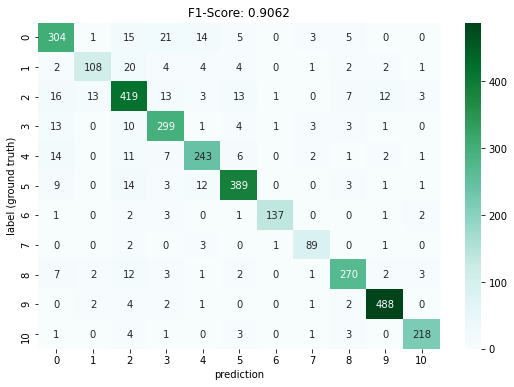

In [57]:
# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred_resnet)   

# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
print(class_names)
print(per_cls_acc)
print("Plot confusion matrix")

# Calculate f1-score
f1 = f1_score(y_true, y_pred, average='micro')

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix, class_names, class_names) 
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')

plt.title(f"F1-Score: {f1:.4f}")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig("report_AI/confusion_matrix_ensemble.png")